# Python: Basics of Double Machine Learning

**Remark**: This notebook has a long computation time due to the large number of simulations.

This notebooks contains the detailed simulations according to the introduction to double machine learning in the [User Guide](https://docs.doubleml.org/stable/guide/basics.html) of the DoubleML package.

In [5]:
import warnings
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import clone

from doubleml import DoubleMLData
from doubleml import DoubleMLPLR
from doubleml.plm.datasets import make_plr_CCDDHNR2018

face_colors = sns.color_palette('pastel')
edge_colors = sns.color_palette('dark')

warnings.filterwarnings("ignore")

## Data Generating Process (DGP)

We consider the following partially linear model:

$$
\begin{align*}
y_i &= \theta_0 d_i + g_0(x_i) + \zeta_i, & \zeta_i \sim \mathcal{N}(0,1), \\
d_i &= m_0(x_i) + v_i, & v_i \sim \mathcal{N}(0,1),
\end{align*}
$$

with covariates $x_i \sim \mathcal{N}(0, \Sigma)$, where $\Sigma$ is a matrix with entries $\Sigma_{kj} = 0.7^{|j-k|}$. We are interested in performing valid inference on the causal parameter $\theta_0$. The true parameter $\theta_0$ is set to $0.5$ in our simulation experiment.

The nuisance functions are given by:

$$
\begin{align*}
m_0(x_i) &= x_{i,1} + \frac{1}{4}  \frac{\exp(x_{i,3})}{1+\exp(x_{i,3})}, \\
g_0(x_i) &= \frac{\exp(x_{i,1})}{1+\exp(x_{i,1})} + \frac{1}{4} x_{i,3}.
\end{align*}
$$

We generate ``n_rep`` replications of the data generating process with sample size ``n_obs`` and compare the performance of different estimators.

In [6]:
np.random.seed(1234)
n_rep = 1000
n_obs = 500
n_vars = 5
alpha = 0.5

data = list()

for i_rep in range(n_rep):
    (x, y, d) = make_plr_CCDDHNR2018(alpha=alpha, n_obs=n_obs, dim_x=n_vars, return_type='array')
    data.append((x, y, d))

## Regularization Bias in Simple ML-Approaches

Naive inference that is based on a direct application of machine learning methods to estimate the causal parameter, $\theta_0$, is generally invalid. The use of machine learning methods introduces a bias that arises due to regularization. A simple ML approach is given by randomly splitting the sample into two parts. On the auxiliary sample indexed by $i \in I^C$ the nuisance function $g_0(X)$ is estimated with an ML method, for example a random forest learner. Given the estimate $\hat{g}_0(X)$, the final estimate of $\theta_0$ is obtained as ($n=N/2$) using the other half of observations indexed with $i \in I$

$$
\hat{\theta}_0 = \left(\frac{1}{n} \sum_{i\in I} D_i^2\right)^{-1} \frac{1}{n} \sum_{i\in I} D_i (Y_i - \hat{g}_0(X_i)).
$$

As this corresponds to a "non-orthogonal" score, which is not implemented in the DoubleML package, we need to define a custom callable.

In [7]:
def non_orth_score(y, d, l_hat, m_hat, g_hat, smpls):
    u_hat = y - g_hat
    psi_a = -np.multiply(d, d)
    psi_b = np.multiply(d, u_hat)
    return psi_a, psi_b

Remark that the estimator is not able to estimate $\hat{g}_0(X)$ directly, but has to be based on a preliminary estimate of $\hat{m}_0(X)$. All following estimators with ``score="IV-type"`` are based on the same preliminary procedure. Furthermore, remark that we are using external predictions to avoid cross-fitting (for demonstration purposes).

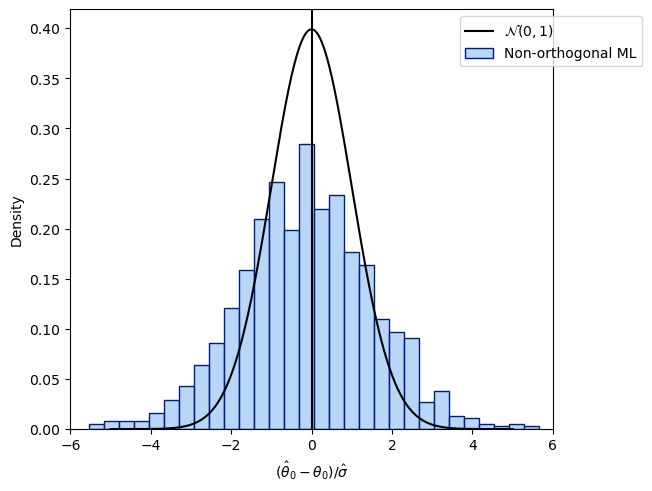

In [8]:
np.random.seed(1111)

ml_l = LGBMRegressor(n_estimators=300, learning_rate=0.1, verbose=-1)
ml_m = LGBMRegressor(n_estimators=300, learning_rate=0.1, verbose=-1)

ml_g = clone(ml_l)

theta_nonorth = np.full(n_rep, np.nan)
se_nonorth = np.full(n_rep, np.nan) 

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]
    
    # choose a random sample for training and estimation
    i_train, i_est = train_test_split(np.arange(n_obs), test_size=0.5, random_state=42)
    
    # fit the ML algorithms on the training sample
    ml_l.fit(x[i_train, :], y[i_train])
    ml_m.fit(x[i_train, :], d[i_train])

    psi_a = -np.multiply(d[i_train] - ml_m.predict(x[i_train, :]), d[i_train] - ml_m.predict(x[i_train, :]))
    psi_b = np.multiply(d[i_train] - ml_m.predict(x[i_train, :]), y[i_train] - ml_l.predict(x[i_train, :]))
    theta_initial = -np.nanmean(psi_b) / np.nanmean(psi_a)
    ml_g.fit(x[i_train, :], y[i_train] - theta_initial * d[i_train])

    # create out-of-sample predictions
    l_hat = ml_l.predict(x[i_est, :])
    m_hat = ml_m.predict(x[i_est, :])
    g_hat = ml_g.predict(x[i_est, :])

    external_predictions = {
        'd': {
            'ml_l': l_hat.reshape(-1, 1),
            'ml_m': m_hat.reshape(-1, 1),
            'ml_g': g_hat.reshape(-1, 1)
        }
    }

    obj_dml_data = DoubleMLData.from_arrays(x[i_est, :], y[i_est], d[i_est])
    obj_dml_plr_nonorth = DoubleMLPLR(obj_dml_data,
                                    ml_l, ml_m, ml_g,
                                    n_folds=2,
                                    score=non_orth_score)
    obj_dml_plr_nonorth.fit(external_predictions=external_predictions)
    theta_nonorth[i_rep] = obj_dml_plr_nonorth.coef[0]
    se_nonorth[i_rep] = obj_dml_plr_nonorth.se[0]

fig_non_orth, ax = plt.subplots(constrained_layout=True);
ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                color=face_colors[0], edgecolor = edge_colors[0],
                stat='density', bins=30, label='Non-orthogonal ML');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.show()

The regularization bias in the simple ML-approach is caused by the slow convergence of $\hat{\theta}_0$

$$
|\sqrt{n} (\hat{\theta}_0 - \theta_0) | \rightarrow_{P} \infty
$$

i.e., slower than $1/\sqrt{n}$.
The driving factor is the bias that arises by learning $g$ with a random forest or any other ML technique.
A heuristic illustration is given by

$$
\sqrt{n}(\hat{\theta}_0 - \theta_0) = \underbrace{\left(\frac{1}{n} \sum_{i\in I} D_i^2\right)^{-1} \frac{1}{n} \sum_{i\in I} D_i \zeta_i}_{=:a}
+  \underbrace{\left(\frac{1}{n} \sum_{i\in I} D_i^2\right)^{-1} \frac{1}{n} \sum_{i\in I} D_i (g_0(X_i) - \hat{g}_0(X_i))}_{=:b}.
$$

$a$ is approximately Gaussian under mild conditions.
However, $b$ (the regularization bias) diverges in general.

## Overcoming regularization bias by orthogonalization

To overcome the regularization bias we can partial out the effect of $X$ from $D$ to obtain the orthogonalized regressor $V = D - m(X)$. We then use the final estimate

$$
\check{\theta}_0 = \left(\frac{1}{n} \sum_{i\in I} \hat{V}_i D_i\right)^{-1} \frac{1}{n} \sum_{i\in I} \hat{V}_i (Y_i - \hat{g}_0(X_i)).
$$

The following figure shows the distribution of the resulting estimates $\hat{\theta}_0$ without sample-splitting. Again, we are using external predictions to avoid cross-fitting (for demonstration purposes).

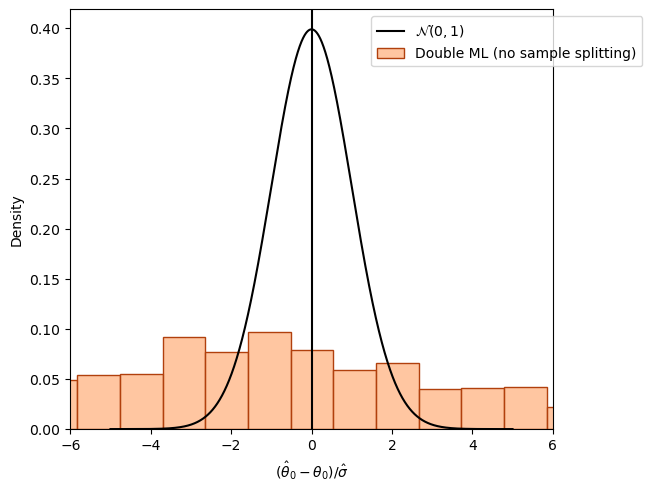

In [9]:
np.random.seed(2222)

theta_orth_nosplit = np.full(n_rep, np.nan)
se_orth_nosplit = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]

    # fit the ML algorithms on the training sample
    ml_l.fit(x, y)
    ml_m.fit(x, d)

    psi_a = -np.multiply(d - ml_m.predict(x), d - ml_m.predict(x))
    psi_b = np.multiply(d - ml_m.predict(x), y - ml_l.predict(x))
    theta_initial = -np.nanmean(psi_b) / np.nanmean(psi_a)
    ml_g.fit(x, y - theta_initial * d)

    l_hat = ml_l.predict(x)
    m_hat = ml_m.predict(x)
    g_hat = ml_g.predict(x)

    external_predictions = {
        'd': {
            'ml_l': l_hat.reshape(-1, 1),
            'ml_m': m_hat.reshape(-1, 1),
            'ml_g': g_hat.reshape(-1, 1)
        }
    }

    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    
    obj_dml_plr_orth_nosplit = DoubleMLPLR(obj_dml_data,
                                        ml_l, ml_m, ml_g,
                                        score='IV-type')
    obj_dml_plr_orth_nosplit.fit(external_predictions=external_predictions)
    theta_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit.coef[0]
    se_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit.se[0]

fig_orth_nosplit, ax = plt.subplots(constrained_layout=True);
ax = sns.histplot((theta_orth_nosplit - alpha)/se_orth_nosplit,
                color=face_colors[1], edgecolor = edge_colors[1],
                stat='density', bins=30, label='Double ML (no sample splitting)');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));    
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.show()

If the nuisance models $\hat{g}_0()$ and $\hat{m}()$ are estimated on the whole dataset, which is also used for obtaining the final estimate $\check{\theta}_0$, another bias is observed.

## Sample splitting to remove bias induced by overfitting

Using sample splitting, i.e., estimate the nuisance models $\hat{g}_0()$ and $\hat{m}()$ on one part of the data (training data) and estimate $\check{\theta}_0$ on the other part of the data (test data), overcomes the bias induced by overfitting. We can exploit the benefits of cross-fitting by switching the role of the training and test sample. Cross-fitting performs well empirically because the entire sample can be used for estimation.

The following figure shows the distribution of the resulting estimates $\hat{\theta}_0$ with orthogonal score and sample-splitting.

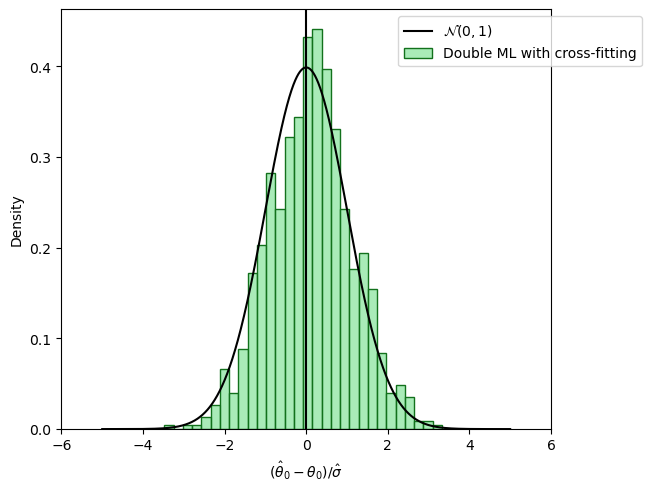

In [10]:
np.random.seed(3333)

theta_dml = np.full(n_rep, np.nan)
se_dml = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_dml_plr = DoubleMLPLR(obj_dml_data,
                            ml_l, ml_m, ml_g,
                            n_folds=2,
                            score='IV-type')
    obj_dml_plr.fit()
    theta_dml[i_rep] = obj_dml_plr.coef[0]
    se_dml[i_rep] = obj_dml_plr.se[0]

fig_dml, ax = plt.subplots(constrained_layout=True);
ax = sns.histplot((theta_dml - alpha)/se_dml,
                color=face_colors[2], edgecolor = edge_colors[2],
                stat='density', bins=30, label='Double ML with cross-fitting');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.show()

## Double/debiased machine learning

To illustrate the benefits of the auxiliary prediction step in the DML framework we write the error as

$$
\sqrt{n}(\check{\theta}_0 - \theta_0) = a^* + b^* + c^*
$$

Chernozhukov et al. (2018) argues that:

The first term

$$
a^* := (EV^2)^{-1} \frac{1}{\sqrt{n}} \sum_{i\in I} V_i \zeta_i
$$

will be asymptotically normally distributed.

The second term

$$
b^* := (EV^2)^{-1} \frac{1}{\sqrt{n}} \sum_{i\in I} (\hat{m}(X_i) - m(X_i)) (\hat{g}_0(X_i) - g_0(X_i))
$$

vanishes asymptotically for many data generating processes.

The third term $c^*$ vanishes in probability if sample splitting is applied. Finally, let us compare all distributions.

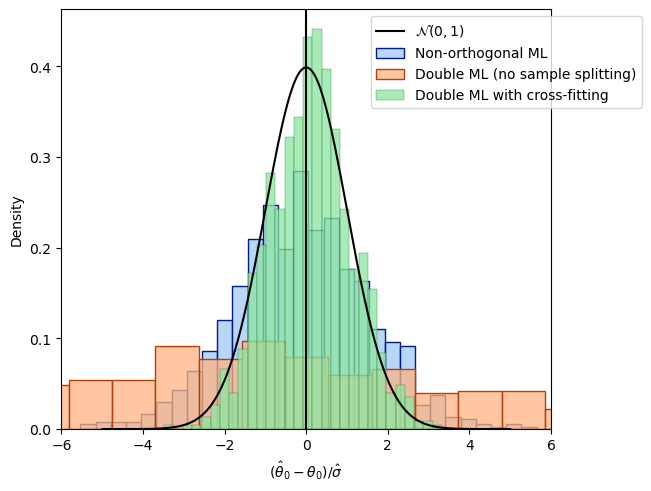

In [11]:
fig_all, ax = plt.subplots(constrained_layout=True);
ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                 color=face_colors[0], edgecolor = edge_colors[0],
                 stat='density', bins=30, label='Non-orthogonal ML');
sns.histplot((theta_orth_nosplit - alpha)/se_orth_nosplit,
             color=face_colors[1], edgecolor = edge_colors[1],
             stat='density', bins=30, label='Double ML (no sample splitting)');
sns.histplot((theta_dml - alpha)/se_dml,
             color=face_colors[2], edgecolor = edge_colors[2],
             stat='density', bins=30, label='Double ML with cross-fitting');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.show()

## Partialling out score

Another debiased estimator, based on the partialling-out approach of Robinson(1988), is

$$
\check{\theta}_0 = \left(\frac{1}{n} \sum_{i\in I} \hat{V}_i \hat{V}_i \right)^{-1} \frac{1}{n} \sum_{i\in I} \hat{V}_i (Y_i - \hat{\ell}_0(X_i)),
$$

with $\ell_0(X_i) = E(Y|X)$.
All nuisance parameters for the estimator with `score='partialling out'` are conditional mean functions, which can be directly estimated using ML methods. This is a minor advantage over the estimator with `score='IV-type'`.
In the following, we repeat the above analysis with `score='partialling out'`. In a first part of the analysis, we estimate $\theta_0$ without sample splitting. Again we observe a bias from overfitting.

The following figure shows the distribution of the resulting estimates $\hat{\theta}_0$ without sample-splitting.

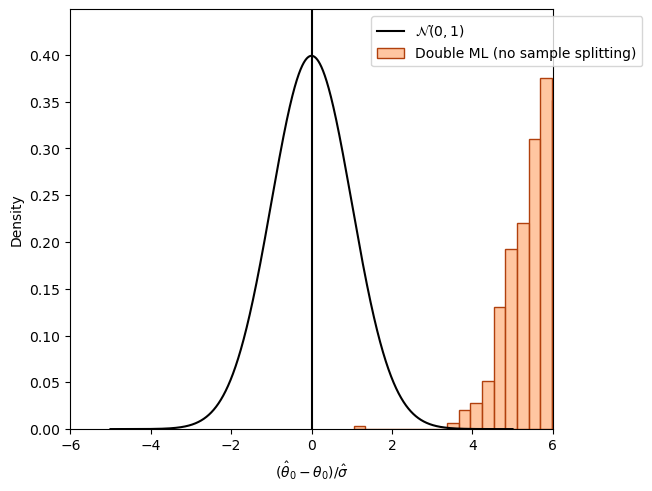

In [12]:
np.random.seed(4444)

theta_orth_po_nosplit = np.full(n_rep, np.nan)
se_orth_po_nosplit = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
     print(f'Replication {i_rep+1}/{n_rep}', end='\r')
     (x, y, d) = data[i_rep]

     # fit the ML algorithms on the training sample
     ml_l.fit(x, y)
     ml_m.fit(x, d)

     l_hat = ml_l.predict(x)
     m_hat = ml_m.predict(x)

     external_predictions = {
          'd': {
               'ml_l': l_hat.reshape(-1, 1),
               'ml_m': m_hat.reshape(-1, 1),
          }
     }

     obj_dml_plr_orth_nosplit = DoubleMLPLR(obj_dml_data,
                                         ml_l, ml_m,
                                         score='partialling out')
     obj_dml_plr_orth_nosplit.fit(external_predictions=external_predictions)
     theta_orth_po_nosplit[i_rep] = obj_dml_plr_orth_nosplit.coef[0]
     se_orth_po_nosplit[i_rep] = obj_dml_plr_orth_nosplit.se[0]

fig_po_nosplit, ax = plt.subplots(constrained_layout=True);
ax = sns.histplot((theta_orth_po_nosplit - alpha)/se_orth_po_nosplit,
                 color=face_colors[1], edgecolor = edge_colors[1],
                 stat='density', bins=30, label='Double ML (no sample splitting)');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.show()

Using sample splitting, overcomes the bias induced by overfitting.
Again, the implementation automatically applies cross-fitting.

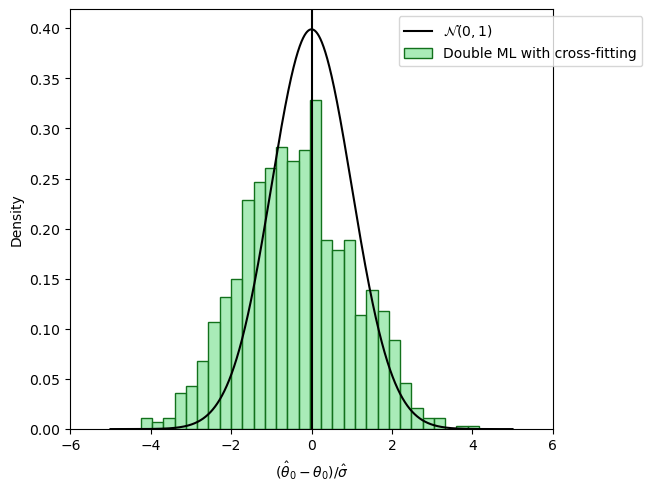

In [13]:
np.random.seed(5555)

theta_dml_po = np.full(n_rep, np.nan)
se_dml_po = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
     print(f'Replication {i_rep+1}/{n_rep}', end='\r')
     (x, y, d) = data[i_rep]
     obj_dml_data = DoubleMLData.from_arrays(x, y, d)
     obj_dml_plr = DoubleMLPLR(obj_dml_data,
                             ml_l, ml_m,
                             n_folds=2,
                             score='partialling out')
     obj_dml_plr.fit()
     theta_dml_po[i_rep] = obj_dml_plr.coef[0]
     se_dml_po[i_rep] = obj_dml_plr.se[0]
 
fig_po_dml, ax = plt.subplots(constrained_layout=True);
ax = sns.histplot((theta_dml_po - alpha)/se_dml_po,
                 color=face_colors[2], edgecolor = edge_colors[2],
                 stat='density', bins=30, label='Double ML with cross-fitting');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.show()

Finally, let us compare all distributions.

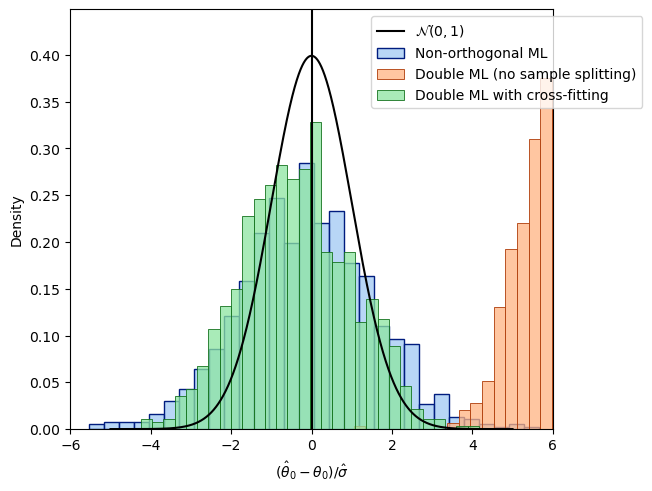

In [14]:
fig_po_all, ax = plt.subplots(constrained_layout=True);
ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                color=face_colors[0], edgecolor = edge_colors[0],
                stat='density', bins=30, label='Non-orthogonal ML');
sns.histplot((theta_orth_po_nosplit - alpha)/se_orth_po_nosplit,
            color=face_colors[1], edgecolor = edge_colors[1],
            stat='density', bins=30, label='Double ML (no sample splitting)');
sns.histplot((theta_dml_po - alpha)/se_dml_po,
            color=face_colors[2], edgecolor = edge_colors[2],
            stat='density', bins=30, label='Double ML with cross-fitting');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');
plt.show()